In [13]:
import pickle
import pandas as pd
pd.set_option('display.max_columns',None)
import itertools
from functools import partial
from collections import defaultdict

import numpy as np
from dyntapy import get_toy_network
from dyntapy.visualization import show_network, show_demand
from dyntapy.supply_data import relabel_graph
from dyntapy.demand_data import od_graph_from_matrix, add_centroids
from dyntapy.results import get_od_flows
from dyntapy.assignments import StaticAssignment

import geopandas as gpd
from typing import Set, Tuple, List, Dict, Optional
import igraph
import random
import logging
from pathlib import Path
from pickle import load
import time
import networkx as nx
from zipfile import ZipFile
import os

# requires local installation of ireiat package using 
from ireiat.util.cacheable import CACHE_PATH

# What this notebook does (or is meant to do) [WIP]

We solve a traffic assignment problem using dyntapy for a subset of O-Ds. To do this, we:

1. Load a highway network into networkx (WIP)
2. Create a BallTree of the networkx nodes
3. Figure out which node should be the "origin" and "destination" for each county (currently a WIP)
4. For each "origin" and "destination" create a separate graph to load into dyntapy's StaticAssignment module
5. Solve the traffic assignment problem using Algorithm B

### First let's solve a toy problem

In [9]:
# load a silly network
g = get_toy_network('cascetta')
labeled_g = relabel_graph(g)
show_network(labeled_g, euclidean=True)

In [10]:
# we've picked some random centroids that are close to nodes 1 and 4 in the original graph
centroid_x = np.array([1, 7])
centroid_y = np.array([1, 1])

# add these centroids as "centroid" nodes (against which O-D flows will be specified)
# also automatically adds connectors (with capacities, etc.) from the centroids to the nearest nodes on the node-link graph
fg = add_centroids(g, centroid_x, centroid_y, euclidean=True) # on the unlabeled graph
fg = relabel_graph(fg)  # adding link and node ids, connectors and centroids
show_network(fg, euclidean=True)

C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\demand_data.py:829: UserWarning: The `euclidean_dist_vec` function has been renamed `euclidean`. Calling `euclidean_dist_vec` will raise an error in a future release.
  dists = euclidean_dist_vec(
C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\demand_data.py:829: UserWarning: The `euclidean_dist_vec` function has been renamed `euclidean`. Calling `euclidean_dist_vec` will raise an error in a future release.
  dists = euclidean_dist_vec(


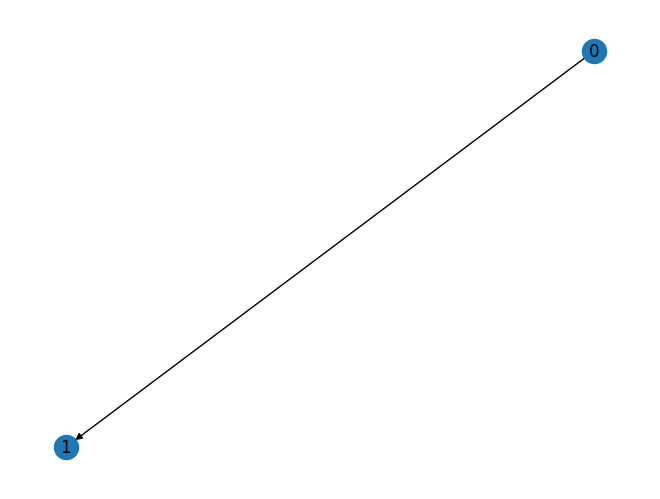

In [11]:
# and for the demand (we want 3000 demand going from centroid 0->1 (which corresponds to node 1->4 on the node-link graph)
od_matrix = np.zeros(len(centroid_x)*len(centroid_y)).reshape((len(centroid_x), len(centroid_y)))
od_matrix[0, 1] = 3000
od_graph = od_graph_from_matrix(od_matrix, centroid_x, centroid_y)
nx.draw(od_graph,with_labels=True)

In [14]:
sa = StaticAssignment(fg, od_graph)

init passed successfully


In [15]:
result = sa.run(method='dial_b') # uses numba, so first run needs compilation time

solution found, Dial B in iteration 1


In [25]:
[(f, some_edge) for f, some_edge in zip(result.flows, fg.edges(data=True)) if some_edge[2].get('connector',False)==False and f > 0]

[(2173.3139814415235,
  (2,
   3,
   {'length': 2.0,
    'capacity': 2000,
    'free_speed': 80,
    'lanes': 1,
    'link_id': 2,
    'from_node_id': 2,
    'to_node_id': 3})),
 (826.6860185584768,
  (2,
   4,
   {'length': 2.0,
    'capacity': 2000,
    'free_speed': 80,
    'lanes': 1,
    'link_id': 3,
    'from_node_id': 2,
    'to_node_id': 4})),
 (2173.3139814415235,
  (3,
   5,
   {'length': 2.0,
    'capacity': 2000,
    'free_speed': 80,
    'lanes': 1,
    'link_id': 6,
    'from_node_id': 3,
    'to_node_id': 5})),
 (826.6860185584768,
  (4,
   5,
   {'length': 2.0,
    'capacity': 500,
    'free_speed': 120,
    'lanes': 1,
    'link_id': 8,
    'from_node_id': 4,
    'to_node_id': 5}))]

### Create a highway network

In [2]:
target_path = '../data/raw/fa5_highway_links.zip'
faf5_links_gdf = gpd.read_file(target_path)

In [12]:
faf5_links_gdf = faf5_links_gdf.to_crs("EPSG:4326")

In [31]:
# faf5_links_gdf.loc[faf5_links_gdf['state'].isin(['NY','NJ']),['geometry']].explore()

In [13]:
%%time
# 6th decimal place is 0.11m in lat/long. IF you go to greater granularity you still get the same number of nodes
# https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
round_to_digits = partial(round,ndigits=6)
def map_start_end_lat_long(row):
    """ Each LINESTRING object consists of lat/longs - and the bounds get the extreme endpoints"""
    long_start, lat_start = map(round_to_digits,  row.geometry.coords[0])
    long_end, lat_end = map(round_to_digits,  row.geometry.coords[-1])
    # return (row.objectid, row.length, (lat_start, long_start), (lat_end, long_end))
    if row.dir==1: # A-> B only
        return [(row.objectid, row.length, row.ctfips, (lat_start, long_start), (lat_end, long_end))]
    elif row.dir==-1: # B->A only
        return [(row.objectid, row.length, row.ctfips, (lat_end, long_end), (lat_start, long_start))]
    else:
        return [(row.objectid, row.length, row.ctfips, (lat_start, long_start), (lat_end, long_end)),
                (row.objectid, row.length, row.ctfips, (lat_end, long_end), (lat_start, long_start))]


# we iterate through the set of links in parallel, extracting formatted endpoints
edge_data = list(itertools.chain.from_iterable([map_start_end_lat_long(row) for row in faf5_links_gdf.itertuples()]))
# edge_data = [map_start_end_lat_long(row) for row in faf5_links_gdf.itertuples()]

CPU times: total: 13.6 s
Wall time: 13.6 s


In [14]:
# create a list of county to node dicts
county_to_node_dict = defaultdict(list)
for obj, length, ctfips, lat_long_start, lat_long_end in edge_data:
    if ctfips:
        state, county = ctfips[:2], ctfips[2:]
        county_to_node_dict[(state,county)].append(lat_long_start)
        county_to_node_dict[(state,county)].append(lat_long_end)

In [16]:
# from the formatted endpoints, we create unique nodes, indexed from 0
node_set: Set[Tuple[float, float]] = {(lat,long) for record in edge_data for lat,long in record[3:]}
node_dict: Dict[Tuple[float, float], int] = {node_lat_long: idx for idx, node_lat_long in enumerate(node_set)}
inv_node_dict: Dict[int, Tuple[float, float]] = {v: k for k,v in node_dict.items()}

# we then map back all the edges
n_vertices = len(node_set)
edge_object_ids = [obj_id for obj_id, _, _, _, _ in edge_data]
edges = [[node_dict[start_node], node_dict[end_node]] for _, _, _, start_node, end_node in edge_data]
edge_distances = [distance for _, distance, _, _, _ in edge_data]

# and we create the highway graph and output it
highway_graph = igraph.Graph(n=n_vertices, 
                             edges=edges, 
                             edge_attrs={'weight':edge_distances}
                            )
highway_graph.write_gml("../data/transformed/highway.gml")

In [17]:
with open('../data/transformed/county_to_node_dict.pickle','wb') as fp:
    pickle.dump(county_to_node_dict, fp)

In [18]:
with open('../data/transformed/node_dict.pickle','wb') as fp:
    pickle.dump(node_dict, fp)

### Load the county OD data and select a random node to associate all county data

In [19]:
logger = logging.getLogger()

In [49]:
county_od = pd.read_parquet('../data/transformed/county_od.parquet')

In [21]:
logger.info("Reading highway graph")
highway_graph = igraph.read("../data/transformed/highway.gml")
with open('../data/transformed/county_to_node_dict.pickle', 'rb') as fp:
    county_to_graph_node_dict = pickle.load(fp)
with open('../data/transformed/node_dict.pickle', 'rb') as fp:
    graph_node_dict = pickle.load(fp)

In [90]:
county_od_sample = county_od.head(200)

In [91]:
%%time

def get_nodes(row) -> Tuple[Optional[float],Optional[float]]:
    candidate_origin_nodes = county_to_node_dict[(row.state_orig,row.county_orig)]
    candidate_dest_nodes = county_to_node_dict[(row.state_dest,row.county_dest)]
    if not (candidate_origin_nodes and candidate_dest_nodes):
        return (-1, -1)
    src_node_id = node_dict[random.choice(candidate_origin_nodes)]
    dest_node_id = node_dict[random.choice(candidate_dest_nodes)]
    return (src_node_id, dest_node_id)
    
# counter = 0

def shortest_path_from_county_od_row(row):
    src_node_id, dest_node_id = get_nodes(row)
    if src_node_id > 0 and dest_node_id > 0:
        path_edges=highway_graph.get_shortest_path(src_node_id,
                                   to=dest_node_id,
                                   weights=highway_graph.es['weight'],
                                   output="epath"
                                   )
        return {'county_od_index': row.Index, 'result': np.array(path_edges)}
    return {'county_od_index': row.Index, 'result': np.array([])}
    
start = time.perf_counter()


result = [shortest_path_from_county_od_row(row) for row in county_od_sample.itertuples()]


    # counter += 1
    # if counter > 500:
    #     break
stop = time.perf_counter()
logger.info(f"Ran in {stop - start:.1f} seconds")

CPU times: total: 7.09 s
Wall time: 7.11 s


In [92]:
pd.DataFrame(result).to_parquet('../data/transformed/naive_result.parquet')

In [93]:
with open('../data/transformed/naive_result.pickle','wb') as fp:
    pickle.dump(result, fp)

1. Methods for stuff

* all or nothing assignment [naive "lowest" impedance path for each O-D pair. does not take into account congestion]
* sequential congestion assignment [order-dependent! not straighforwardly parallelizable. not obvious what the congestion function is...]
* probablistic assignment on top k "low impedance" candidate paths [picking candidates is hard]
* really cool convex programming problem [intractable]
    - for all flow paths between O-D, have some power (quadratic?) cost function with constraints